#### 因子投资作业——计算 return_1m, turn_1m, std_1m, std_FF3factor_1m 因子并测试效果
##### 3200103563 何柔含

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sml
import os
from dateutil.relativedelta import relativedelta 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter('ignore')
#设置绘图字体
plt.rcParams['font.sans-serif']=['SimHei']
#解决绘图时候坐标轴负值部分的显示问题
plt.rcParams['axes.unicode_minus']=False

In [2]:
#数据读取
filesource = "../Data/"

files = os.listdir(filesource)
#for file in files:
for i in range(len(files)):
    df = pd.read_csv(filesource+files[i])
    df_name = 'rawdata'+str(i)
    globals()[df_name] = df

In [3]:
close_day          = rawdata0.rename(columns={"Unnamed: 0":"security_code"}).copy()
stock_code         = rawdata1.drop(columns='Unnamed: 0')
delist_date        = rawdata2.rename(columns={"Unnamed: 0":"security_code"}).copy()
float_a_shares_day = rawdata3.rename(columns={"Unnamed: 0":"security_code"}).copy()
pb_lf_day          = rawdata4.rename(columns={"Unnamed: 0":"security_code"}).copy()
csiall_day         = rawdata5
close_adj_day      = rawdata6.rename(columns={"Unnamed: 0":"security_code"}).copy()
turn_day           = rawdata7.rename(columns={"Unnamed: 0":"security_code"}).copy()
IPO_date           = rawdata8.rename(columns={"Unnamed: 0":"security_code"}).copy()
cs_indus_code_day  = rawdata9.rename(columns={"Unnamed: 0":"security_code"}).copy()
share_totala_day   = rawdata10.rename(columns={"Unnamed: 0":"security_code"}).copy()
amt_day            = rawdata11.rename(columns={"Unnamed: 0":"security_code"}).copy()
month              = rawdata12.drop(columns='Unnamed: 0')
day                = rawdata13.drop(columns='Unnamed: 0')

In [4]:
#股票池筛选
IPO_date['IPO_date'] = pd.to_datetime(IPO_date['IPO_date'])
delist_date['delist_date'] = pd.to_datetime(delist_date['delist_date'])

df_stock = pd.DataFrame(columns=['security_code'])

for iter_month in month['date']:
    #ipo_list上市满252天的股票代码列表
    ipo_list = IPO_date[IPO_date['IPO_date']<pd.to_datetime(iter_month) - pd.offsets.BusinessDay(n=252)]['security_code'].to_list()
    #delist_date在截面日前已退市的股票
    delist_list = delist_date[delist_date['delist_date']<pd.to_datetime(iter_month)]['security_code'].to_list()
    #分别匹配三个筛选条件
    df_temp = amt_day.loc[amt_day[iter_month]!=0][['security_code',iter_month]]
    df_temp = df_temp.loc[(df_temp['security_code'].isin(ipo_list))&(~df_temp['security_code'].isin(delist_list))]
    df_temp = df_temp.melt(id_vars=['security_code'], var_name='date', value_name='volumn')
    
    df_stock = pd.concat([df_stock,df_temp])

df_stock = df_stock.drop(columns=['volumn'])

In [5]:
#因子值计算
df_month = month.loc[(month['date']>'2010-12-15')&(month['date']<='2023-05-31')]
month_slct_factor_cal = df_month['date'].to_list()
list_stock = df_stock['security_code'].drop_duplicates().to_list()
df_stock_used = df_stock[df_stock['date'].isin(month_slct_factor_cal)]#在要求时间范围内的股票池

return_1m = close_adj_day.copy()
turn_1m = turn_day.copy()
std_1m = close_adj_day.copy()

for iter_month in df_month['date']:
    b21 = day['date'].iloc[day[day['date'] == iter_month].index-21].item()
    return_1m[iter_month] = close_adj_day.loc[:,[b21,iter_month]].pct_change(axis = 1).iloc[:,1]
    turn_1m[iter_month] = turn_day.loc[:,b21:iter_month].mean(axis = 1)
    std_1m[iter_month] = close_adj_day.loc[:,b21:iter_month].pct_change(axis = 1).std(axis = 1)

return_1m = return_1m.set_index('security_code').loc[list_stock,month_slct_factor_cal].reset_index()
turn_1m = turn_1m.set_index('security_code').loc[list_stock,month_slct_factor_cal].reset_index()
std_1m = std_1m.set_index('security_code').loc[list_stock,month_slct_factor_cal].reset_index()

In [6]:
#计算std_FF3factor_1m
#csiall_daily_return = csiall_day.copy()
market_value = share_totala_day.fillna(0).set_index('security_code').mul(close_day.fillna(0).set_index('security_code'))
std_FF3factor_1m = pd.DataFrame(index=return_1m['security_code'],columns=return_1m.columns[1:])

def calculate_smb(df_return, market_value):
    smb_df = pd.DataFrame(index = ['SMB'],columns=days_cal)
    for iter_day in days_cal:
        current_mv = market_value.loc[stock_for_cal_list,b21:iter_month][[iter_day]].dropna().rename(columns = {iter_day:'market_value'})
        current_rr = df_return[[iter_day]].reset_index().rename(columns = {iter_day:'return_rate'})
        current_data = pd.merge(current_rr,current_mv,on = 'security_code')
        current_data['group'] = pd.qcut(current_data['market_value'], q=[0, 0.3,0.7,1], labels = ['S','M','B'])
        current_data= current_data.groupby('group')['return_rate'].mean()
        smb_df[iter_day] = current_data['S']-current_data['B']
    return smb_df

def calculate_hml(df_return, df_pb):
    hml_df = pd.DataFrame(index = ['HML'],columns=days_cal)
    for iter_day in days_cal:
        current_mv = df_pb.set_index('security_code').loc[stock_for_cal_list,b21:iter_month][[iter_day]].dropna().rename(columns = {iter_day:'pb_ratio'})
        current_rr = df_return[[iter_day]].reset_index().rename(columns = {iter_day:'return_rate'})
        current_data = pd.merge(current_rr,current_mv,on = 'security_code')
        current_data['group'] = pd.qcut(current_data['pb_ratio'], q=[0, 0.3,0.7,1], labels = ['H','M','L'])
        current_data= current_data.groupby('group')['return_rate'].mean()
        hml_df[iter_day] = current_data['H']-current_data['L']
    return hml_df

for iter_month in df_month['date']:
    b21 = day['date'].iloc[day[day['date'] == iter_month].index-21].item()
    stock_for_cal_list = df_stock[df_stock['date'] == iter_month]['security_code'].to_list()
    days_cal = market_value.loc[stock_for_cal_list,b21:iter_month].columns.to_list()[1:]

    #计算日收益率和中证全指日收益率
    stock_daily_return = close_adj_day.set_index('security_code').loc[:,b21:iter_month].pct_change(axis = 1).iloc[:,1:]#日收益率
    csiall_daily_return = csiall_day.loc[:,b21:iter_month].pct_change(axis = 1).iloc[:,1:]#中证全指收益率

    #计算SMB因子收益率
    smb_factor = calculate_smb(stock_daily_return, market_value)
    #计算HML因子收益率
    hml_factor = calculate_hml(stock_daily_return, pb_lf_day)
    del days_cal,b21

    merged_data = pd.merge(hml_factor.T, smb_factor.T,left_index=True, right_index=True)
    merged_data = pd.merge(merged_data, csiall_daily_return.T,left_index=True, right_index=True).rename(columns = {0:'csi'})
    
    #回归
    for security_code in stock_for_cal_list:
        if stock_daily_return.loc[security_code].isnull().any() == True:
            continue
        else:
            y = stock_daily_return.loc[security_code].values.reshape(-1, 1)
            x = merged_data.values.reshape(-1,3)
            model = LinearRegression()
            model.fit(x, y)
            residuals = y - model.predict(x)
            residual_std = np.std(residuals)
            std_FF3factor_1m.loc[security_code,iter_month]=residual_std
        del y,x,residuals
    print(iter_month+'finished')

std_FF3factor_1m = std_FF3factor_1m.reset_index()

2010-12-31finished
2011-01-31finished
2011-02-28finished
2011-03-31finished
2011-04-29finished
2011-05-31finished
2011-06-30finished
2011-07-29finished
2011-08-31finished
2011-09-30finished
2011-10-31finished
2011-11-30finished
2011-12-30finished
2012-01-31finished
2012-02-29finished
2012-03-30finished
2012-04-27finished
2012-05-31finished
2012-06-29finished
2012-07-31finished
2012-08-31finished
2012-09-28finished
2012-10-31finished
2012-11-30finished
2012-12-31finished
2013-01-31finished
2013-02-28finished
2013-03-29finished
2013-04-26finished
2013-05-31finished
2013-06-28finished
2013-07-31finished
2013-08-30finished
2013-09-30finished
2013-10-31finished
2013-11-29finished
2013-12-31finished
2014-01-30finished
2014-02-28finished
2014-03-31finished
2014-04-30finished
2014-05-30finished
2014-06-30finished
2014-07-31finished
2014-08-29finished
2014-09-30finished
2014-10-31finished
2014-11-28finished
2014-12-31finished
2015-01-30finished
2015-02-27finished
2015-03-31finished
2015-04-30fi

In [7]:
#保存原始因子值
return_1m = return_1m.melt(id_vars=['security_code'], var_name='date', value_name='return_1m')
return_1m = pd.merge(return_1m,df_stock_used,on = ['security_code','date'],how = 'right')
return_1m.pivot(index='date', columns='security_code',values='return_1m').to_csv('../Result/factor_1_raw.csv')

turn_1m = turn_1m.melt(id_vars=['security_code'], var_name='date', value_name='turn_1m')
turn_1m = pd.merge(turn_1m,df_stock_used,on = ['security_code','date'],how = 'right')
turn_1m.pivot(index='date', columns='security_code',values='turn_1m').to_csv('../Result/factor_2_raw.csv')

std_1m = std_1m.melt(id_vars=['security_code'], var_name='date', value_name='std_1m')
std_1m = pd.merge(std_1m,df_stock_used,on = ['security_code','date'],how = 'right')
std_1m.pivot(index='date', columns='security_code',values='std_1m').to_csv('../Result/factor_3_raw.csv')

std_FF3factor_1m = std_FF3factor_1m.melt(id_vars=['security_code'], var_name='date', value_name='std_FF3factor_1m')
std_FF3factor_1m = pd.merge(std_FF3factor_1m,df_stock_used,on = ['security_code','date'],how = 'right')
std_FF3factor_1m['std_FF3factor_1m'] = std_FF3factor_1m['std_FF3factor_1m'].astype(float)
std_FF3factor_1m.pivot(index='date', columns='security_code',values='std_FF3factor_1m').to_csv('../Result/factor_4_raw.csv')

In [8]:
#因子去极值
def winsorize_std(data,scale=3): 
    upper = data.mean() + scale*data.std()
    lower = data.mean() - scale*data.std()
    return np.clip(data,lower,upper)
    
def get_f_3std(factor,factorname):
    #factor = factor.fillna(0)#.melt(id_vars=['security_code'], var_name='date', value_name=factorname)
    fname = factor.columns[2]
    factor['date'] = pd.to_datetime(factor['date'])
    factor['year'] = factor['date'].apply(lambda x:x.year)
    factor = factor.set_index(['security_code','date'])
    factor = factor.groupby('year').apply(lambda x:winsorize_std(x[fname])).reset_index()
    return factor

return_1m = get_f_3std(return_1m,'return_1m')
turn_1m = get_f_3std(turn_1m,'turn_1m')
std_1m = get_f_3std(std_1m,'std_1m')
std_FF3factor_1m = get_f_3std(std_FF3factor_1m,'std_FF3factor_1m')

In [9]:
#行业市值中性化_数据预处理
cs_indus_code = cs_indus_code_day.melt(id_vars=['security_code'], var_name='date', value_name='industry_code')
cs_indus_code['date'] = pd.to_datetime(cs_indus_code['date'])

float_mkt_value = float_a_shares_day.set_index('security_code').mul(close_day.set_index('security_code'))
float_mkt_value = float_mkt_value.reset_index().melt(id_vars=['security_code'], var_name='date', value_name='mkt_value')
float_mkt_value['date'] = pd.to_datetime(float_mkt_value['date'])

def get_merged_factor_ind(data):
    data = pd.merge(data,cs_indus_code,on = ['security_code','date'],how = 'left')
    data = pd.merge(data,float_mkt_value,on = ['security_code','date'],how = 'left')
    data['date'] = data['date'].apply(lambda x:x.strftime('%Y-%m-%d'))
    data = data.drop(columns = 'year')
    print('finished')
    return data

return_1m = get_merged_factor_ind(return_1m).dropna()
turn_1m = get_merged_factor_ind(turn_1m).dropna()
std_1m = get_merged_factor_ind(std_1m).dropna()
std_FF3factor_1m = get_merged_factor_ind(std_FF3factor_1m).dropna()

finished
finished
finished
finished


In [12]:
#行业市值中性化
def OlsResid(y,x):
    df = pd.concat([y,x],axis = 1)#.dropna()

    if df.dropna().shape[0]>0:    
        resid = sm.OLS(df.iloc[:,0],df.iloc[:,1:].astype(float),missing='drop').fit().resid   
        return resid.reindex(df.index)
    else:
        return y

def norm(data,if_neutral):
    """
    数据预处理，标准化
    """    
    # 判断有无缺失值，若有缺失值，drop，若都缺失，返回原值
    datax = data.copy()
    if data.shape[0] != 0:
        classname = data['industry_code']
        mkt = data['mkt_value']
        data = data.drop(['industry_code','mkt_value'],axis = 1)

        ## 去极值
        data = data.apply(lambda x:winsorize_std(x),axis = 0)
        ## 中性化
        if if_neutral:  # 是否中性
          
            class_var = pd.get_dummies(classname,columns=['industry_code'],prefix='industry_code',
                                       prefix_sep="_", dummy_na=False, drop_first=True)   
            class_var['mktcap'] = np.log(mkt)
            class_var['mktcap'] = class_var['mktcap'].replace([np.inf,-np.inf],np.nan)
            #class_var['Intercept'] = 1
            x = class_var.dropna(subset='mktcap')
        # 每个因子对所有自变量做回归，得到残差值
            data = data.apply(func = OlsResid, args = (x,), axis = 0)                     
         
           ## zscore
        data1 = (data - data.mean())/data.std() 

        # 缺失部分补进去
        data1 = data1.reindex(datax.index)
    else:
        data1 = data                  
    return data1


"""
调用norm在对每月的因子做截面上的中性化
"""
def NormFactors(datas,if_neutral):
    # datas = factorall.copy()
    fnormall = []

    dates = datas.date.unique()

    for dateuse in dates: # dateuse = dates[0]
        datause = datas.loc[datas.date == dateuse]
        stockname = datause[['date','security_code']]
        fnorm = norm(datause.drop(['date','security_code'],axis = 1),if_neutral)
        fnormall.append(pd.concat([stockname,fnorm],axis = 1))
        print('{}中性化完成！'.format(dateuse))
    fnormall = pd.concat(fnormall,axis = 0)
    fnormall = fnormall.sort_values(by = ['date','security_code'])
    return fnormall.reset_index(drop = True)

return_1m_norm = NormFactors(return_1m,True)
turn_1m_norm = NormFactors(turn_1m,True)
std_1m_norm = NormFactors(std_1m,True)
std_FF3factor_1m_norm = NormFactors(std_FF3factor_1m,True)

2010-12-31中性化完成！
2011-01-31中性化完成！
2011-02-28中性化完成！
2011-03-31中性化完成！
2011-04-29中性化完成！
2011-05-31中性化完成！
2011-06-30中性化完成！
2011-07-29中性化完成！
2011-08-31中性化完成！
2011-09-30中性化完成！
2011-10-31中性化完成！
2011-11-30中性化完成！
2011-12-30中性化完成！
2012-01-31中性化完成！
2012-02-29中性化完成！
2012-03-30中性化完成！
2012-04-27中性化完成！
2012-05-31中性化完成！
2012-06-29中性化完成！
2012-07-31中性化完成！
2012-08-31中性化完成！
2012-09-28中性化完成！
2012-10-31中性化完成！
2012-11-30中性化完成！
2012-12-31中性化完成！
2013-01-31中性化完成！
2013-02-28中性化完成！
2013-03-29中性化完成！
2013-04-26中性化完成！
2013-05-31中性化完成！
2013-06-28中性化完成！
2013-07-31中性化完成！
2013-08-30中性化完成！
2013-09-30中性化完成！
2013-10-31中性化完成！
2013-11-29中性化完成！
2013-12-31中性化完成！
2014-01-30中性化完成！
2014-02-28中性化完成！
2014-03-31中性化完成！
2014-04-30中性化完成！
2014-05-30中性化完成！
2014-06-30中性化完成！
2014-07-31中性化完成！
2014-08-29中性化完成！
2014-09-30中性化完成！
2014-10-31中性化完成！
2014-11-28中性化完成！
2014-12-31中性化完成！
2015-01-30中性化完成！
2015-02-27中性化完成！
2015-03-31中性化完成！
2015-04-30中性化完成！
2015-05-29中性化完成！
2015-06-30中性化完成！
2015-07-31中性化完成！
2015-08-31中性化完成！
2015-09-30中性化完成！
2015-10-30中性化完

In [13]:
#标准化
def cal_zscore(data):
    zscore_f = (data - data.mean()) / data.std()
    return zscore_f

return_1m_norm['return_1m'] = cal_zscore(return_1m_norm['return_1m'])
turn_1m_norm['turn_1m'] = cal_zscore(turn_1m_norm['turn_1m'])
std_1m_norm['std_1m'] = cal_zscore(std_1m_norm['std_1m'])
std_FF3factor_1m_norm['std_FF3factor_1m'] = cal_zscore(std_FF3factor_1m_norm['std_FF3factor_1m'])

In [14]:
#保存预处理后因子值
return_1m_norm.pivot(index='date', columns='security_code',values='return_1m').to_csv('../Result/factor_1_processed.csv')
turn_1m_norm.pivot(index='date', columns='security_code',values='turn_1m').to_csv('../Result/factor_2_processed.csv')
std_1m_norm.pivot(index='date', columns='security_code',values='std_1m').to_csv('../Result/factor_3_processed.csv')
std_FF3factor_1m_norm.pivot(index='date', columns='security_code',values='std_FF3factor_1m').to_csv('../Result/factor_4_processed.csv')

In [15]:
#因子检验-计算下个月自然收益率
ret = close_adj_day.set_index('security_code').loc[:,month_slct_factor_cal].pct_change(1,axis = 1)
ret = ret.T.reset_index().rename(columns = {'index':'date'}).set_index('date')
ret = ret.shift(-1).fillna(0)
ret = ret.stack().reset_index()
ret = ret.rename(columns = {ret.columns[2]:'ret'})
ret = pd.merge(ret,df_stock,on = ['security_code','date'],how = 'right')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


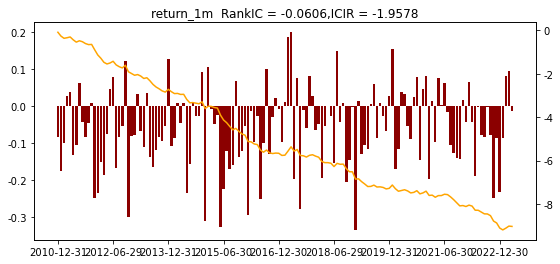

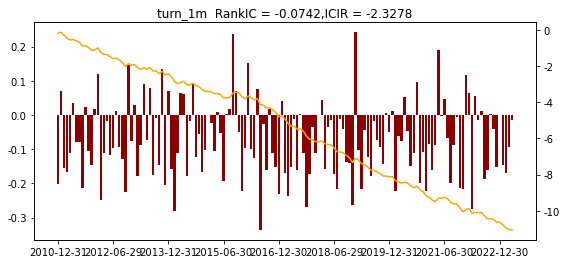

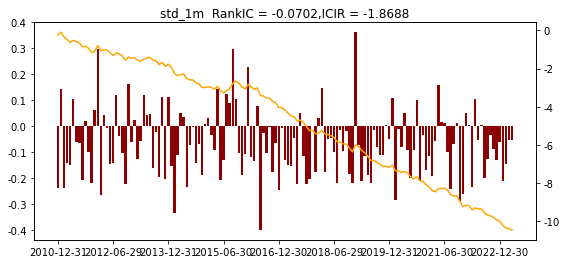

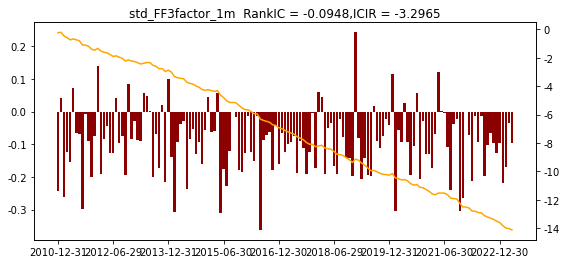

In [16]:
#因子检验-RankIC
def getICSeries(factors,ret,method):

    icall = pd.DataFrame()  
    fall = pd.merge(factors,ret,left_on = ['date','security_code'],right_on = ['date','security_code'])
    icall = fall.groupby('date').apply(lambda x:x.corr(method = method)['ret']).reset_index()    
    icall = icall.dropna().drop(['ret'],axis = 1).set_index('date')

    return icall    

def plotIC(ic_f):
    """
    IC作图
    """
    fname = ic_f.columns[0]
    fig = plt.figure(figsize = (9,4))
    ax = plt.axes()
    xtick = np.arange(0,ic_f.shape[0],18)
    xticklabel = pd.Series(ic_f.index[xtick])
    plt.bar(np.arange(ic_f.shape[0]),ic_f[fname],color = 'darkred')
    ax1 = plt.twinx()
    ax1.plot(np.arange(ic_f.shape[0]),ic_f[fname].cumsum(),color = 'orange')
    ax.set_xticks(xtick)
    ax.set_xticklabels(xticklabel)    
    plt.title(fname + '  RankIC = {},ICIR = {}'.format(round(ic_f[fname].mean(),4),\
                                                    round(ic_f[fname].mean()/ic_f[fname].std()*np.sqrt(12),4)))
    plt.savefig('../Result/累计RankIC_'+fname+'.png')

ic_return = getICSeries(return_1m_norm,ret,'spearman')
ic_turn = getICSeries(turn_1m_norm,ret,'spearman')
ic_std = getICSeries(std_1m_norm,ret,'spearman')
ic_std_FF3factor_1m = getICSeries(std_FF3factor_1m_norm,ret,'spearman')

plotIC(ic_return)
plotIC(ic_turn)
plotIC(ic_std)
plotIC(ic_std_FF3factor_1m) 

In [17]:
#分层测试法
def GroupTestAllFactors_1(factors,ret,groups):
    # factors = fnorm.copy();groups = 10

    fnames = factors.columns
    fall = pd.merge(factors,ret,left_on = ['security_code','date'],right_on = ['security_code','date']).fillna(0)
    Groupret = []
    Groupturnover = []
    
    f= fnames[2]
    if ((f != 'security_code')&(f != 'date')):
            fuse = fall.copy()[['security_code','date','ret',f]]
            # 计算每只股票在每个日期所属的group，按照因子值从小到大等分，注意这里
            # 每组的标志分别为1，2，3，4，5
            fuse['groups'] = fuse[f].groupby(fuse.date).apply(lambda x:np.ceil(x.rank()/(len(x)/groups)))
            result = fuse.groupby(['date','groups']).apply(lambda x:x.ret.mean())
            result = result.unstack().reset_index()
                
    result.insert(0,'factor',f)
    Groupret.append(result)
    
    Groupret = pd.concat(Groupret,axis = 0).reset_index(drop = True)
    
    # 计算每一组的累积收益率
    Groupnav = Groupret.iloc[:,2:].groupby(Groupret.factor).apply(lambda x:(1 + x).cumprod())
    Groupnav = pd.concat([Groupret[['date','factor']],Groupnav],axis = 1)

    return Groupret,Groupnav

In [18]:
def plotnav(Groupnav):
    """
    GroupTest作图
    """
    f = Groupnav.factor.unique()[0]
    fnav = Groupnav.loc[Groupnav.factor ==f,:].set_index('date').iloc[:,1:]
    groups = fnav.shape[1]

    
    plt.figure(figsize = (10,5))      
    for i in range(groups):
        plt.plot(np.arange(fnav.shape[0]),fnav.iloc[:,i],linewidth = 2,linestyle = '-')
    plt.legend(list(range(groups)))
    plt.title('Factor Stratification Test:' + f,fontsize = 20)
    plt.savefig('../Result/因子分层测试 ：' + f +'.png')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


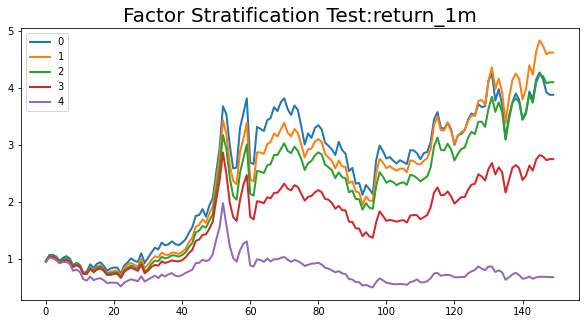

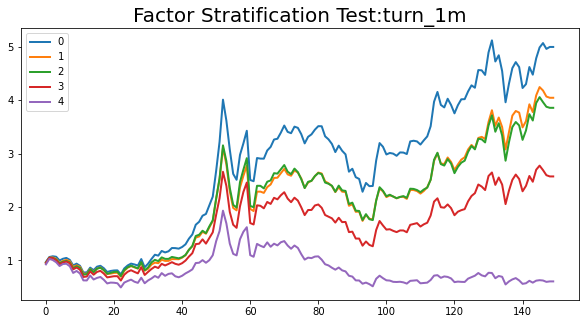

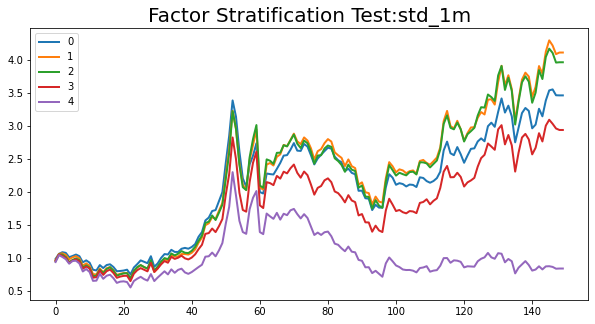

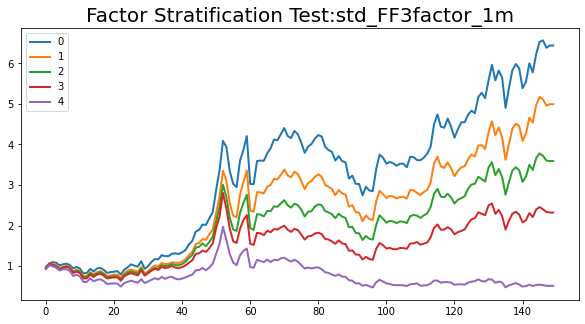

In [19]:
Groupret_return,Groupnav_return = GroupTestAllFactors_1(return_1m_norm,ret,5)
plotnav(Groupnav_return)
Groupret_turn,Groupnav_turn = GroupTestAllFactors_1(turn_1m_norm,ret,5)
plotnav(Groupnav_turn)
Groupret_std,Groupnav_std = GroupTestAllFactors_1(std_1m_norm,ret,5)
plotnav(Groupnav_std)
Groupret_std_ff3,Groupnav_std_ff3 = GroupTestAllFactors_1(std_FF3factor_1m_norm,ret,5)
plotnav(Groupnav_std_ff3)

In [20]:
#保存四个因子的RankIC时间序列、5分层收益率序列
pd.merge(Groupret_return,ic_return.reset_index().rename(columns={'return_1m':'RankIC'}),on = 'date').drop(columns=['factor']).set_index('date').to_csv('../Result/factor_1_test.csv')
pd.merge(Groupret_turn,ic_turn.reset_index().rename(columns={'turn_1m':'RankIC'}),on = 'date').drop(columns=['factor']).set_index('date').to_csv('../Result/factor_2_test.csv')
pd.merge(Groupret_std,ic_std.reset_index().rename(columns={'std_1m':'RankIC'}),on = 'date').drop(columns=['factor']).set_index('date').to_csv('../Result/factor_3_test.csv')
pd.merge(Groupret_std_ff3,ic_std_FF3factor_1m.reset_index().rename(columns={'std_FF3factor_1m':'RankIC'}),on = 'date').drop(columns=['factor']).set_index('date').to_csv('../Result/factor_4_test.csv')